# Chapter 11 – Training Deep Neural Networks

This notebook contains all the sample code and solutions to the exercises in chapter 11.

## Setup
This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the ```images/deep``` folder (if it doesn't already exist), and define the ```save_fig()``` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Vanishing/Exploding Gradients Problem

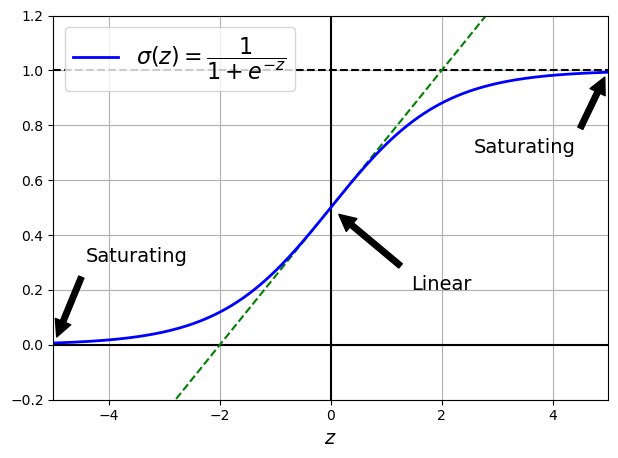

In [6]:
# extra code – this cell generates and saves Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [7]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [8]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions
### Leaky ReLU

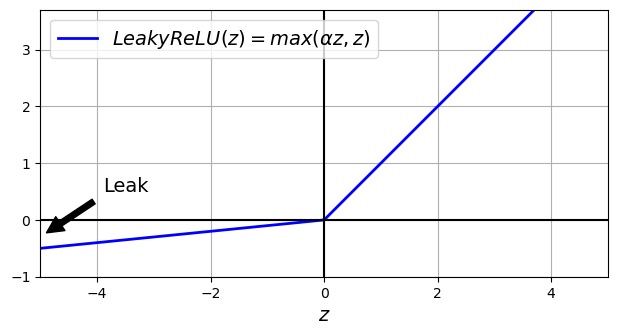

In [9]:
# extra code – this cell generates and saves Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()


In [10]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [11]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU
Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [12]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU
By default, the SELU hyperparameters (```scale``` and ```alpha```) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

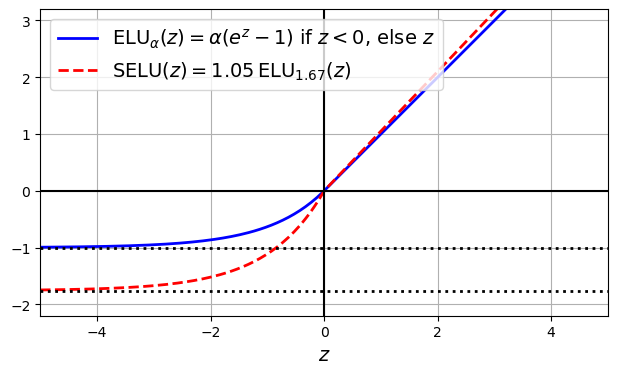

In [13]:
# extra code – this cell generates and saves Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [14]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**Extra material – an example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [15]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [17]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [20]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

#scaling the data
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [21]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


1719/1719 [==============================] - 12s 6ms/step - loss: 1.2386 - accuracy: 0.5436 - val_loss: 0.8234 - val_accuracy: 0.6962
Epoch 2/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8780 - accuracy: 0.7009 - val_loss: 0.8252 - val_accuracy: 0.7076
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7950 - accuracy: 0.7227 - val_loss: 0.6748 - val_accuracy: 0.7702
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6188 - accuracy: 0.7837 - val_loss: 0.5667 - val_accuracy: 0.8066
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5490 - accuracy: 0.8093 - val_loss: 0.5344 - val_accuracy: 0.8132


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [22]:
tf.random.set_seed(42)

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [24]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [25]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 11s 5ms/step - loss: 1.9522 - accuracy: 0.1949 - val_loss: 1.5776 - val_accuracy: 0.3332
Epoch 2/5
1719/1719 [==============================] - 8s 4ms/step - loss: 1.4425 - accuracy: 0.3928 - val_loss: 1.1589 - val_accuracy: 0.5146
Epoch 3/5
1719/1719 [==============================] - 8s 5ms/step - loss: 1.0990 - accuracy: 0.5537 - val_loss: 1.1941 - val_accuracy: 0.5164
Epoch 4/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.9812 - accuracy: 0.6003 - val_loss: 0.8486 - val_accuracy: 0.6596
Epoch 5/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.8408 - accuracy: 0.6623 - val_loss: 0.8009 - val_accuracy: 0.6878


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

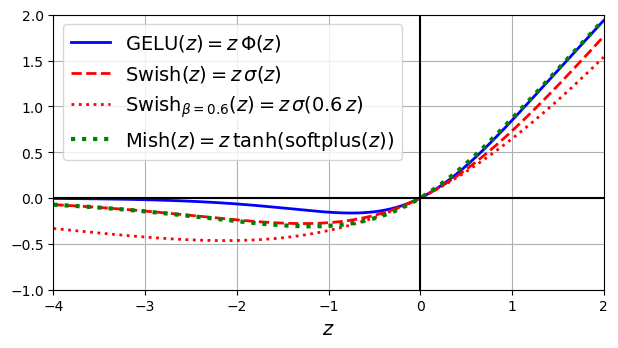

In [26]:
# extra code – this cell generates and saves Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

## Batch Normalization

In [27]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [30]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [31]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))


Epoch 1/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5563 - accuracy: 0.8077 - val_loss: 0.3968 - val_accuracy: 0.8558
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4070 - accuracy: 0.8567 - val_loss: 0.3639 - val_accuracy: 0.8672



Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a ```BatchNormalization``` layer does not need to have bias terms, since the ```BatchNormalization``` layer some as well, it would be a waste of parameters, so you can set ```use_bias=False``` when creating those layers:

In [32]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [34]:

# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 2s 983us/step - loss: 0.5939 - accuracy: 0.8006 - val_loss: 0.4240 - val_accuracy: 0.8450
Epoch 2/2
1719/1719 [==============================] - 2s 898us/step - loss: 0.4209 - accuracy: 0.8537 - val_loss: 0.3692 - val_accuracy: 0.8644


## Gradient Clipping

All ```tf.keras.optimizers``` accept ```clipnorm``` or ```clipvalue``` arguments:

In [35]:

optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [36]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers
### Reusing a Keras model

Let's split the fashion MNIST training set in two:

* ```X_train_A```: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* ```X_train_B```: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.
The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [37]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A.keras")

Epoch 1/20
1376/1376 [==============================] - 1s 847us/step - loss: 1.1579 - accuracy: 0.6411 - val_loss: 0.6955 - val_accuracy: 0.7884
Epoch 2/20
1376/1376 [==============================] - 1s 740us/step - loss: 0.5949 - accuracy: 0.8170 - val_loss: 0.5078 - val_accuracy: 0.8393
Epoch 3/20
1376/1376 [==============================] - 1s 738us/step - loss: 0.4776 - accuracy: 0.8492 - val_loss: 0.4369 - val_accuracy: 0.8559
Epoch 4/20
1376/1376 [==============================] - 1s 739us/step - loss: 0.4207 - accuracy: 0.8649 - val_loss: 0.3958 - val_accuracy: 0.8684
Epoch 5/20
1376/1376 [==============================] - 1s 734us/step - loss: 0.3852 - accuracy: 0.8735 - val_loss: 0.3681 - val_accuracy: 0.8714
Epoch 6/20
1376/1376 [==============================] - 1s 742us/step - loss: 0.3607 - accuracy: 0.8807 - val_loss: 0.3497 - val_accuracy: 0.8779
Epoch 7/20
1376/1376 [==============================] - 1s 744us/step - loss: 0.3427 - accuracy: 0.8849 - val_loss: 0.3350 -

In [38]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 19ms/step - loss: 0.7146 - accuracy: 0.4350 - val_loss: 0.6895 - val_accuracy: 0.5134
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.4950 - val_loss: 0.6740 - val_accuracy: 0.5776
Epoch 3/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6797 - accuracy: 0.5850 - val_loss: 0.6591 - val_accuracy: 0.6825
Epoch 4/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6620 - accuracy: 0.6700 - val_loss: 0.6468 - val_accuracy: 0.7359
Epoch 5/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6482 - accuracy: 0.7400 - val_loss: 0.6345 - val_accuracy: 0.7864
Epoch 6/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6344 - accuracy: 0.7700 - val_loss: 0.6222 - val_accuracy: 0.8160
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6205 - accuracy: 0.7900 - val_loss: 0.6104 - val_accuracy: 0.8447
Epoch 8/20
7/7 [=================

[0.4830686151981354, 0.9254999756813049]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [39]:
model_A = tf.keras.models.load_model("my_model_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that ```model_B_on_A``` and ```model_A``` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build ```model_B_on_A``` on top of a clone of ```model_A```:

In [40]:

tf.random.set_seed(42)  # extra code – ensure reproducibility

In [41]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [42]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [43]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [44]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 18ms/step - loss: 1.2027 - accuracy: 0.4450 - val_loss: 0.8985 - val_accuracy: 0.4748
Epoch 2/4
7/7 [==============================] - 0s 6ms/step - loss: 0.8828 - accuracy: 0.3850 - val_loss: 0.7805 - val_accuracy: 0.4184
Epoch 3/4
7/7 [==============================] - 0s 6ms/step - loss: 0.7942 - accuracy: 0.3900 - val_loss: 0.7547 - val_accuracy: 0.4787
Epoch 4/4
7/7 [==============================] - 0s 6ms/step - loss: 0.7567 - accuracy: 0.4650 - val_loss: 0.7365 - val_accuracy: 0.5074
Epoch 1/16
7/7 [==============================] - 0s 17ms/step - loss: 0.7064 - accuracy: 0.5900 - val_loss: 0.6504 - val_accuracy: 0.6449
Epoch 2/16
7/7 [==============================] - 0s 5ms/step - loss: 0.6230 - accuracy: 0.7100 - val_loss: 0.5693 - val_accuracy: 0.8032
Epoch 3/16
7/7 [==============================] - 0s 5ms/step - loss: 0.5444 - accuracy: 0.8350 - val_loss: 0.5245 - val_accuracy: 0.8051
Epoch 4/16
7/7 [====================

So, what's the final verdict?

In [45]:

model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 548us/step - loss: 0.2940 - accuracy: 0.9275


[0.2940099537372589, 0.9275000095367432]

Great! We got a bit of transfer: the model's accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%: (closer to 11% for me)

In [48]:
1 - (100 - 92.75) / (100 - 91.85)

0.11042944785276132

## Faster Optimizers

In [49]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [51]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 795us/step - loss: 0.6760 - accuracy: 0.7673 - val_loss: 0.4905 - val_accuracy: 0.8224
Epoch 2/10
1719/1719 [==============================] - 1s 722us/step - loss: 0.4598 - accuracy: 0.8395 - val_loss: 0.4325 - val_accuracy: 0.8436
Epoch 3/10
1719/1719 [==============================] - 1s 727us/step - loss: 0.4166 - accuracy: 0.8526 - val_loss: 0.4075 - val_accuracy: 0.8540
Epoch 4/10
1719/1719 [==============================] - 1s 721us/step - loss: 0.3904 - accuracy: 0.8620 - val_loss: 0.3812 - val_accuracy: 0.8618
Epoch 5/10
1719/1719 [==============================] - 1s 724us/step - loss: 0.3701 - accuracy: 0.8684 - val_loss: 0.3702 - val_accuracy: 0.8650
Epoch 6/10
1719/1719 [==============================] - 1s 722us/step - loss: 0.3580 - accuracy: 0.8721 - val_loss: 0.3723 - val_accuracy: 0.8630
Epoch 7/10
1719/1719 [==============================] - 1s 723us/step - loss: 0.3413 - accuracy: 0.8764 - val_loss: 0.3694 -

### Momentum optimization

In [52]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [53]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 794us/step - loss: 0.7079 - accuracy: 0.7561 - val_loss: 0.5069 - val_accuracy: 0.8200
Epoch 2/10
1719/1719 [==============================] - 1s 714us/step - loss: 0.4671 - accuracy: 0.8361 - val_loss: 0.4509 - val_accuracy: 0.8362
Epoch 3/10
1719/1719 [==============================] - 1s 717us/step - loss: 0.4197 - accuracy: 0.8512 - val_loss: 0.4157 - val_accuracy: 0.8538
Epoch 4/10
1719/1719 [==============================] - 1s 714us/step - loss: 0.3930 - accuracy: 0.8612 - val_loss: 0.3815 - val_accuracy: 0.8634
Epoch 5/10
1719/1719 [==============================] - 1s 715us/step - loss: 0.3714 - accuracy: 0.8690 - val_loss: 0.3713 - val_accuracy: 0.8602
Epoch 6/10
1719/1719 [==============================] - 1s 716us/step - loss: 0.3572 - accuracy: 0.8721 - val_loss: 0.3643 - val_accuracy: 0.8680
Epoch 7/10
1719/1719 [==============================] - 1s 712us/step - loss: 0.3414 - accuracy: 0.8776 - val_loss: 0.3747 -

### Nesterov Accelerated Gradient

In [54]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [55]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 778us/step - loss: 0.6967 - accuracy: 0.7607 - val_loss: 0.4969 - val_accuracy: 0.8218
Epoch 2/10
1719/1719 [==============================] - 1s 731us/step - loss: 0.4659 - accuracy: 0.8364 - val_loss: 0.4509 - val_accuracy: 0.8328
Epoch 3/10
1719/1719 [==============================] - 1s 728us/step - loss: 0.4224 - accuracy: 0.8498 - val_loss: 0.4031 - val_accuracy: 0.8552
Epoch 4/10
1719/1719 [==============================] - 1s 731us/step - loss: 0.3963 - accuracy: 0.8601 - val_loss: 0.3813 - val_accuracy: 0.8604
Epoch 5/10
1719/1719 [==============================] - 1s 728us/step - loss: 0.3762 - accuracy: 0.8668 - val_loss: 0.3698 - val_accuracy: 0.8636
Epoch 6/10
1719/1719 [==============================] - 1s 729us/step - loss: 0.3623 - accuracy: 0.8706 - val_loss: 0.3781 - val_accuracy: 0.8652
Epoch 7/10
1719/1719 [==============================] - 1s 732us/step - loss: 0.3467 - accuracy: 0.8761 - val_loss: 0.3751 -

### AdaGrad

In [56]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [57]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 825us/step - loss: 1.0435 - accuracy: 0.6668 - val_loss: 0.6929 - val_accuracy: 0.7742
Epoch 2/10
1719/1719 [==============================] - 1s 752us/step - loss: 0.6460 - accuracy: 0.7896 - val_loss: 0.5791 - val_accuracy: 0.8108
Epoch 3/10
1719/1719 [==============================] - 1s 756us/step - loss: 0.5711 - accuracy: 0.8121 - val_loss: 0.5319 - val_accuracy: 0.8216
Epoch 4/10
1719/1719 [==============================] - 1s 759us/step - loss: 0.5338 - accuracy: 0.8239 - val_loss: 0.5071 - val_accuracy: 0.8278
Epoch 5/10
1719/1719 [==============================] - 1s 752us/step - loss: 0.5098 - accuracy: 0.8309 - val_loss: 0.4885 - val_accuracy: 0.8322
Epoch 6/10
1719/1719 [==============================] - 1s 760us/step - loss: 0.4926 - accuracy: 0.8359 - val_loss: 0.4789 - val_accuracy: 0.8328
Epoch 7/10
1719/1719 [==============================] - 1s 758us/step - loss: 0.4794 - accuracy: 0.8385 - val_loss: 0.4660 -

### RMSProp

In [58]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [59]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 853us/step - loss: 0.5185 - accuracy: 0.8125 - val_loss: 0.4770 - val_accuracy: 0.8250
Epoch 2/10
1719/1719 [==============================] - 1s 795us/step - loss: 0.3953 - accuracy: 0.8580 - val_loss: 0.4005 - val_accuracy: 0.8618
Epoch 3/10
1719/1719 [==============================] - 1s 748us/step - loss: 0.3666 - accuracy: 0.8687 - val_loss: 0.4007 - val_accuracy: 0.8622
Epoch 4/10
1719/1719 [==============================] - 1s 751us/step - loss: 0.3581 - accuracy: 0.8753 - val_loss: 0.3746 - val_accuracy: 0.8712
Epoch 5/10
1719/1719 [==============================] - 1s 758us/step - loss: 0.3510 - accuracy: 0.8776 - val_loss: 0.3923 - val_accuracy: 0.8692
Epoch 6/10
1719/1719 [==============================] - 1s 749us/step - loss: 0.3475 - accuracy: 0.8799 - val_loss: 0.4648 - val_accuracy: 0.8586
Epoch 7/10
1719/1719 [==============================] - 1s 754us/step - loss: 0.3470 - accuracy: 0.8783 - val_loss: 0.4360 -

### Adam Optimization

In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [61]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 830us/step - loss: 0.5011 - accuracy: 0.8205 - val_loss: 0.4275 - val_accuracy: 0.8338
Epoch 2/10
1719/1719 [==============================] - 1s 787us/step - loss: 0.3766 - accuracy: 0.8635 - val_loss: 0.4025 - val_accuracy: 0.8468
Epoch 3/10
1719/1719 [==============================] - 1s 784us/step - loss: 0.3410 - accuracy: 0.8755 - val_loss: 0.3456 - val_accuracy: 0.8764
Epoch 4/10
1719/1719 [==============================] - 1s 785us/step - loss: 0.3159 - accuracy: 0.8839 - val_loss: 0.3391 - val_accuracy: 0.8770
Epoch 5/10
1719/1719 [==============================] - 1s 783us/step - loss: 0.2974 - accuracy: 0.8904 - val_loss: 0.3241 - val_accuracy: 0.8802
Epoch 6/10
1719/1719 [==============================] - 1s 789us/step - loss: 0.2829 - accuracy: 0.8942 - val_loss: 0.3361 - val_accuracy: 0.8846
Epoch 7/10
1719/1719 [==============================] - 1s 783us/step - loss: 0.2698 - accuracy: 0.8990 - val_loss: 0.3508 -

### Adamax Optimization

In [62]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [63]:

history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 862us/step - loss: 0.5494 - accuracy: 0.8111 - val_loss: 0.4550 - val_accuracy: 0.8302
Epoch 2/10
1719/1719 [==============================] - 1s 776us/step - loss: 0.4017 - accuracy: 0.8574 - val_loss: 0.3954 - val_accuracy: 0.8530
Epoch 3/10
1719/1719 [==============================] - 1s 777us/step - loss: 0.3635 - accuracy: 0.8689 - val_loss: 0.3638 - val_accuracy: 0.8684
Epoch 4/10
1719/1719 [==============================] - 1s 773us/step - loss: 0.3387 - accuracy: 0.8782 - val_loss: 0.3397 - val_accuracy: 0.8734
Epoch 5/10
1719/1719 [==============================] - 1s 775us/step - loss: 0.3172 - accuracy: 0.8853 - val_loss: 0.3271 - val_accuracy: 0.8830
Epoch 6/10
1719/1719 [==============================] - 1s 777us/step - loss: 0.3037 - accuracy: 0.8898 - val_loss: 0.3340 - val_accuracy: 0.8774
Epoch 7/10
1719/1719 [==============================] - 1s 772us/step - loss: 0.2900 - accuracy: 0.8932 - val_loss: 0.3529 -

### Nadam Optimization

In [64]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [65]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 900us/step - loss: 0.4846 - accuracy: 0.8283 - val_loss: 0.4047 - val_accuracy: 0.8468
Epoch 2/10
1719/1719 [==============================] - 1s 827us/step - loss: 0.3661 - accuracy: 0.8666 - val_loss: 0.3838 - val_accuracy: 0.8542
Epoch 3/10
1719/1719 [==============================] - 1s 827us/step - loss: 0.3330 - accuracy: 0.8782 - val_loss: 0.3420 - val_accuracy: 0.8758
Epoch 4/10
1719/1719 [==============================] - 1s 829us/step - loss: 0.3127 - accuracy: 0.8855 - val_loss: 0.3364 - val_accuracy: 0.8806
Epoch 5/10
1719/1719 [==============================] - 1s 833us/step - loss: 0.2941 - accuracy: 0.8911 - val_loss: 0.3318 - val_accuracy: 0.8776
Epoch 6/10
1719/1719 [==============================] - 1s 826us/step - loss: 0.2792 - accuracy: 0.8964 - val_loss: 0.3791 - val_accuracy: 0.8774
Epoch 7/10
1719/1719 [==============================] - 1s 828us/step - loss: 0.2703 - accuracy: 0.8988 - val_loss: 0.3684 -

### AdamW Optimization

Note: Since TF 1.12, ```AdamW``` is no longer experimental. It is available at ```tf.keras.optimizers.AdamW``` instead of ```tf.keras.optimizers.experimental.AdamW```.

In [66]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [67]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 836us/step - loss: 0.4995 - accuracy: 0.8209 - val_loss: 0.4257 - val_accuracy: 0.8326
Epoch 2/10
1719/1719 [==============================] - 1s 790us/step - loss: 0.3760 - accuracy: 0.8631 - val_loss: 0.3933 - val_accuracy: 0.8456
Epoch 3/10
1719/1719 [==============================] - 1s 792us/step - loss: 0.3403 - accuracy: 0.8736 - val_loss: 0.3534 - val_accuracy: 0.8738
Epoch 4/10
1719/1719 [==============================] - 1s 791us/step - loss: 0.3180 - accuracy: 0.8835 - val_loss: 0.3305 - val_accuracy: 0.8732
Epoch 5/10
1719/1719 [==============================] - 1s 790us/step - loss: 0.2996 - accuracy: 0.8894 - val_loss: 0.3324 - val_accuracy: 0.8726
Epoch 6/10
1719/1719 [==============================] - 1s 791us/step - loss: 0.2843 - accuracy: 0.8935 - val_loss: 0.3640 - val_accuracy: 0.8730
Epoch 7/10
1719/1719 [==============================] - 1s 788us/step - loss: 0.2729 - accuracy: 0.8971 - val_loss: 0.3234 -

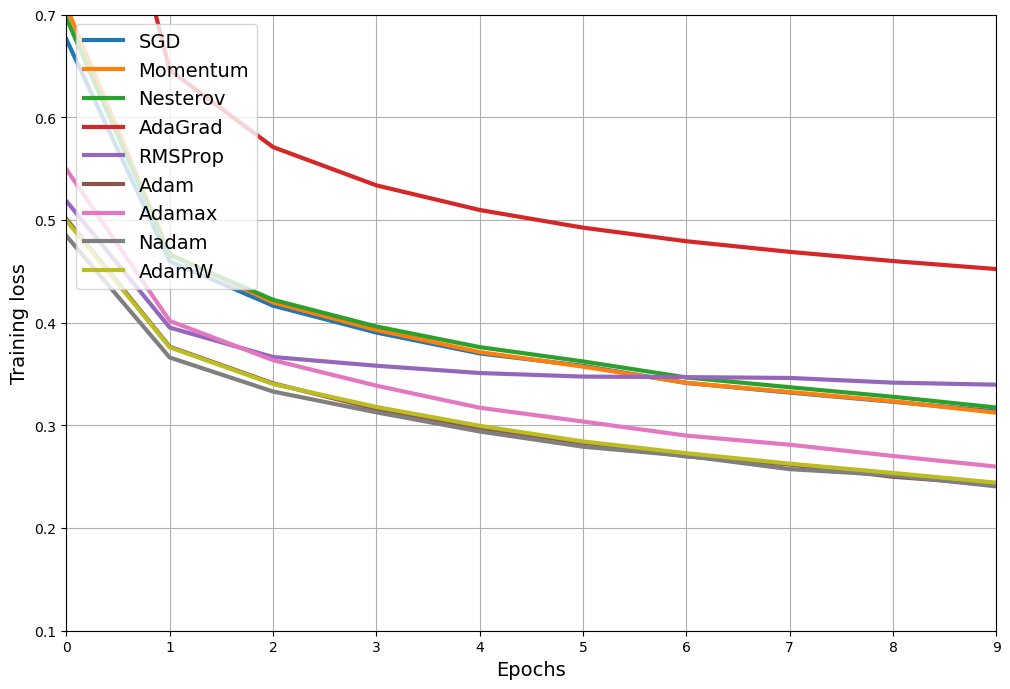

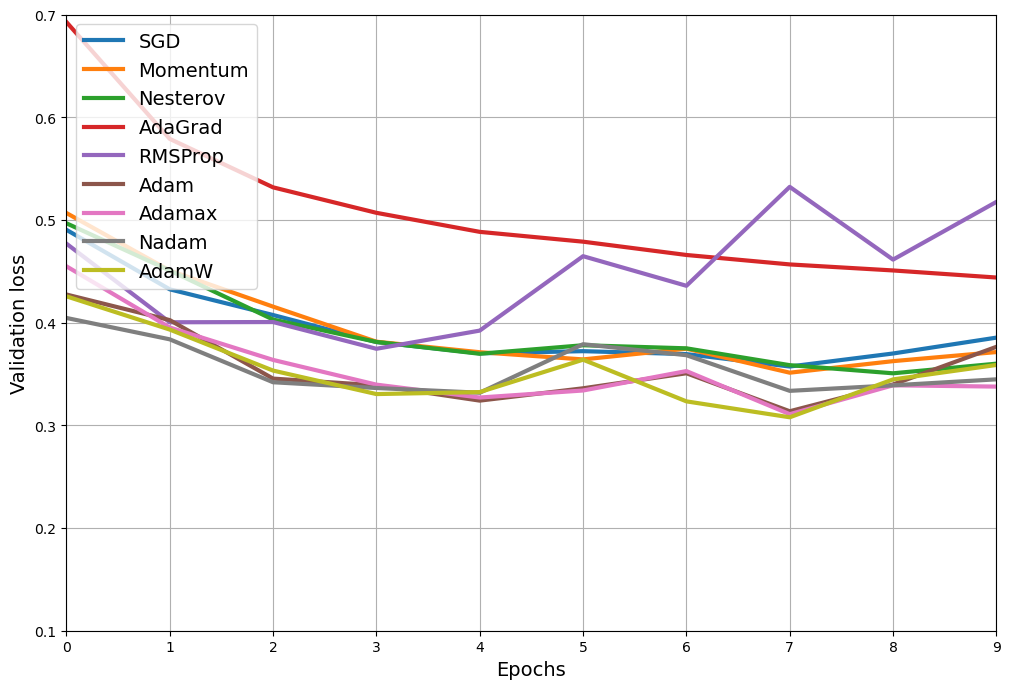

In [68]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```learning_rate = initial_learning_rate / (1 + step / decay_steps)**power```

Keras uses ```power = 1```.



**Note**: Optimizers used to have a ```decay``` argument for this, but it was deprecated. You must use the schedulers in ```tf.keras.optimizers.schedules``` instead.

In [69]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

The ```InverseTimeDecay``` scheduler uses ```learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)```. If you set ```staircase=True```, then it replaces ```step / decay_step``` with ```floor(step / decay_step)```.

In [70]:

history_power_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 795us/step - loss: 0.6850 - accuracy: 0.7619 - val_loss: 0.4961 - val_accuracy: 0.8242
Epoch 2/10
1719/1719 [==============================] - 1s 737us/step - loss: 0.4734 - accuracy: 0.8349 - val_loss: 0.4500 - val_accuracy: 0.8376
Epoch 3/10
1719/1719 [==============================] - 1s 741us/step - loss: 0.4283 - accuracy: 0.8478 - val_loss: 0.4146 - val_accuracy: 0.8528
Epoch 4/10
1719/1719 [==============================] - 1s 724us/step - loss: 0.4053 - accuracy: 0.8576 - val_loss: 0.3941 - val_accuracy: 0.8620
Epoch 5/10
1719/1719 [==============================] - 1s 723us/step - loss: 0.3883 - accuracy: 0.8637 - val_loss: 0.3866 - val_accuracy: 0.8634
Epoch 6/10
1719/1719 [==============================] - 1s 759us/step - loss: 0.3743 - accuracy: 0.8673 - val_loss: 0.3920 - val_accuracy: 0.8646
Epoch 7/10
1719/1719 [==============================] - 1s 753us/step - loss: 0.3647 - accuracy: 0.8701 - val_loss: 0.3743 -

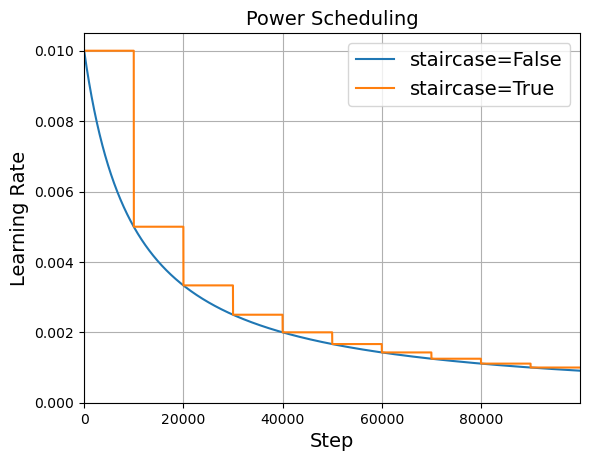

In [71]:
# extra code – this cell plots power scheduling with staircase=True or False

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## Exponential Scheduling
```learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)```

In [72]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [73]:
history_exponential_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 765us/step - loss: 0.6923 - accuracy: 0.7616 - val_loss: 0.4909 - val_accuracy: 0.8300
Epoch 2/10
1719/1719 [==============================] - 1s 712us/step - loss: 0.4773 - accuracy: 0.8327 - val_loss: 0.4552 - val_accuracy: 0.8334
Epoch 3/10
1719/1719 [==============================] - 1s 717us/step - loss: 0.4334 - accuracy: 0.8455 - val_loss: 0.4180 - val_accuracy: 0.8508
Epoch 4/10
1719/1719 [==============================] - 1s 725us/step - loss: 0.4107 - accuracy: 0.8559 - val_loss: 0.3998 - val_accuracy: 0.8578
Epoch 5/10
1719/1719 [==============================] - 1s 725us/step - loss: 0.3934 - accuracy: 0.8610 - val_loss: 0.3929 - val_accuracy: 0.8584
Epoch 6/10
1719/1719 [==============================] - 1s 718us/step - loss: 0.3808 - accuracy: 0.8655 - val_loss: 0.3945 - val_accuracy: 0.8606
Epoch 7/10
1719/1719 [==============================] - 1s 721us/step - loss: 0.3724 - accuracy: 0.8676 - val_loss: 0.3812 -

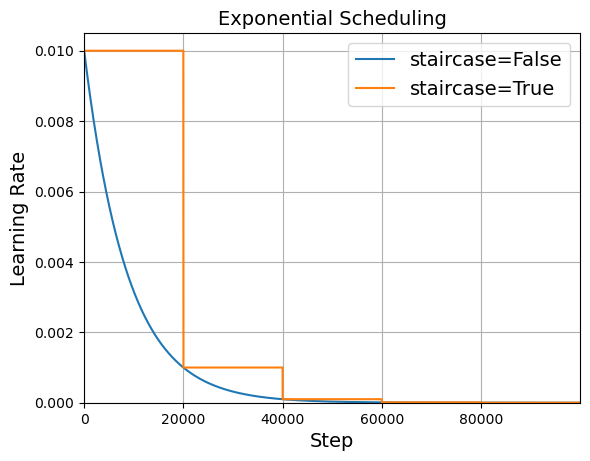

In [74]:
# extra code – this cell plots exponential scheduling

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Keras also provides a ```LearningRateScheduler``` callback class that lets you define your own scheduling function. Let's see how you could use it to implement exponential decay. Note that in this case the learning rate only changes at each epoch, not at each step:

In [75]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [76]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [77]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [78]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 [==============================] - 2s 772us/step - loss: 0.6768 - accuracy: 0.7671 - val_loss: 0.4857 - val_accuracy: 0.8316 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 1s 717us/step - loss: 0.4665 - accuracy: 0.8354 - val_loss: 0.4502 - val_accuracy: 0.8374 - lr: 0.0089
Epoch 3/20
1719/1719 [==============================] - 1s 719us/step - loss: 0.4218 - accuracy: 0.8505 - val_loss: 0.4204 - val_accuracy: 0.8516 - lr: 0.0079
Epoch 4/20
1719/1719 [==============================] - 1s 722us/step - loss: 0.3988 - accuracy: 0.8593 - val_loss: 0.3840 - val_accuracy: 0.8622 - lr: 0.0071
Epoch 5/20
1719/1719 [==============================] - 1s 716us/step - loss: 0.3807 - accuracy: 0.8649 - val_loss: 0.3809 - val_accuracy: 0.8642 - lr: 0.0063
Epoch 6/20
1719/1719 [==============================] - 1s 720us/step - loss: 0.3662 - accuracy: 0.8704 - val_loss: 0.3800 - val_accuracy: 0.8654 - lr: 0.0056
Epoch 7/20
1719/1719 [========================

Alternatively, the schedule function can take the current learning rate as a second argument:

In [79]:

def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to use a custom scheduling function that updates the learning rate at each iteration rather than at each epoch, you can write your own callback class like this:

In [80]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = self.model.optimizer.learning_rate.numpy()
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        self.model.optimizer.learning_rate = new_learning_rate

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.learning_rate.numpy()

In [81]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [82]:
import math

batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/20
1719/1719 [==============================] - 2s 956us/step - loss: 0.6719 - accuracy: 0.7701 - val_loss: 0.4850 - val_accuracy: 0.8236 - lr: 0.0089
Epoch 2/20
1719/1719 [==============================] - 2s 888us/step - loss: 0.4638 - accuracy: 0.8368 - val_loss: 0.4555 - val_accuracy: 0.8346 - lr: 0.0079
Epoch 3/20
1719/1719 [==============================] - 2s 889us/step - loss: 0.4195 - accuracy: 0.8520 - val_loss: 0.4126 - val_accuracy: 0.8520 - lr: 0.0071
Epoch 4/20
1719/1719 [==============================] - 2s 898us/step - loss: 0.3967 - accuracy: 0.8607 - val_loss: 0.3910 - val_accuracy: 0.8606 - lr: 0.0063
Epoch 5/20
1719/1719 [==============================] - 2s 889us/step - loss: 0.3788 - accuracy: 0.8667 - val_loss: 0.3872 - val_accuracy: 0.8622 - lr: 0.0056
Epoch 6/20
1719/1719 [==============================] - 2s 890us/step - loss: 0.3653 - accuracy: 0.8701 - val_loss: 0.3861 - val_accuracy: 0.8602 - lr: 0.0050
Epoch 7/20
1719/1719 [========================

## Piecewise Constant Scheduling

In [83]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [84]:
history_piecewise_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 2s 826us/step - loss: 0.6906 - accuracy: 0.7659 - val_loss: 0.4758 - val_accuracy: 0.8326
Epoch 2/10
1719/1719 [==============================] - 1s 771us/step - loss: 0.4635 - accuracy: 0.8365 - val_loss: 0.4427 - val_accuracy: 0.8436
Epoch 3/10
1719/1719 [==============================] - 1s 733us/step - loss: 0.4148 - accuracy: 0.8508 - val_loss: 0.4025 - val_accuracy: 0.8590
Epoch 4/10
1719/1719 [==============================] - 1s 730us/step - loss: 0.3896 - accuracy: 0.8607 - val_loss: 0.3778 - val_accuracy: 0.8652
Epoch 5/10
1719/1719 [==============================] - 1s 729us/step - loss: 0.3689 - accuracy: 0.8671 - val_loss: 0.3709 - val_accuracy: 0.8674
Epoch 6/10
1719/1719 [==============================] - 1s 734us/step - loss: 0.3533 - accuracy: 0.8724 - val_loss: 0.3795 - val_accuracy: 0.8672
Epoch 7/10
1719/1719 [==============================] - 1s 732us/step - loss: 0.3419 - accuracy: 0.8756 - val_loss: 0.3590 -

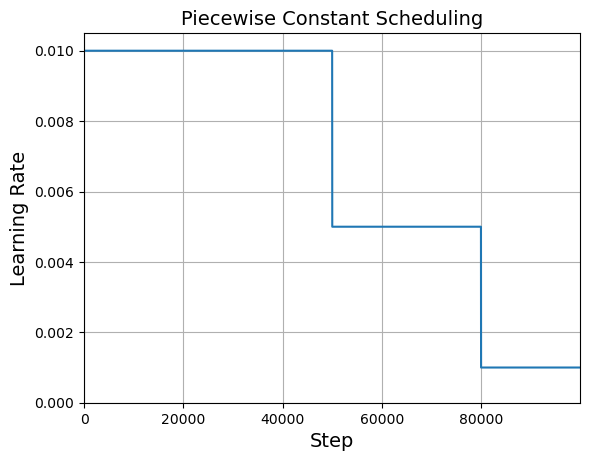

In [85]:
# extra code – this cell plots piecewise constant scheduling

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Just like we did with exponential scheduling, we could also implement piecewise constant scheduling manually:

In [86]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [87]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [88]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 932us/step - loss: 0.5499 - accuracy: 0.8056 - val_loss: 0.4615 - val_accuracy: 0.8282 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 873us/step - loss: 0.4510 - accuracy: 0.8413 - val_loss: 0.4593 - val_accuracy: 0.8342 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 1s 828us/step - loss: 0.4345 - accuracy: 0.8460 - val_loss: 0.4453 - val_accuracy: 0.8418 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 1s 830us/step - loss: 0.4143 - accuracy: 0.8535 - val_loss: 0.4428 - val_accuracy: 0.8448 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 1s 832us/step - loss: 0.4034 - accuracy: 0.8599 - val_loss: 0.4129 - val_accuracy: 0.8434 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 1s 828us/step - loss: 0.3543 - accuracy: 0.8717 - val_loss: 0.3839 - val_accuracy: 0.8598 - lr: 0.0050
Epoch 7/25
1719/1719 [========================

We've looked at ```InverseTimeDecay```, ```ExponentialDecay```, and ```PiecewiseConstantDecay```. A few more schedulers are available in ```tf.keras.optimizers.schedules```, here is the full list:

In [89]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay – A LearningRateSchedule that uses a cosine decay with optional warmup.
• CosineDecayRestarts – A LearningRateSchedule that uses a cosine decay schedule with restarts.
• ExponentialDecay – A LearningRateSchedule that uses an exponential decay schedule.
• InverseTimeDecay – A LearningRateSchedule that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A LearningRateSchedule that uses a piecewise constant decay schedule.
• PolynomialDecay – A LearningRateSchedule that uses a polynomial decay schedule.


### Performance Scheduling